In [1]:
import selfies as sf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import NamedTuple
from dataclasses import dataclass, asdict
import json

@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_size: int
        
config = Config(128, 20000, 64, 1000, 256, 128)

In [2]:
dir(config)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'batch_size',
 'buffer_size',
 'embedding_dim',
 'example_number',
 'rnn_size',
 'vocab_size']

## Get Vocab

In [3]:
data_url = 'https://github.com/aspuru-guzik-group/selfies/raw/16a489afa70882428bc194b2b24a2d33573f1651/examples/vae_example/datasets/dataJ_250k_rndm_zinc_drugs_clean.txt'

pd_data = pd.read_csv(data_url)
selfies_list = list(map(sf.encoder, pd_data.iloc[:config.example_number, 0]))
all_selfies_symbols = ['[nop]']
all_selfies_symbols += sf.get_alphabet_from_selfies(selfies_list)
vocab_stoi = {o:i for o,i in zip(all_selfies_symbols, range(len(all_selfies_symbols)))}
print(vocab_stoi)

{'[nop]': 0, '[\\S-expl]': 1, '[/NH+expl]': 2, '[=OH+expl]': 3, '[S@@expl]': 4, '[\\C]': 5, '[Branch1_3]': 6, '[NHexpl]': 7, '[NH2+expl]': 8, '[/S@expl]': 9, '[P]': 10, '[/C@Hexpl]': 11, '[F]': 12, '[/S-expl]': 13, '[\\O]': 14, '[=C]': 15, '[=PH2expl]': 16, '[P@expl]': 17, '[S]': 18, '[/Cl]': 19, '[P@@Hexpl]': 20, '[#C]': 21, '[=P]': 22, '[\\C@@Hexpl]': 23, '[=N]': 24, '[\\S]': 25, '[N+expl]': 26, '[/N]': 27, '[P@@expl]': 28, '[C@@expl]': 29, '[=N+expl]': 30, '[=NH2+expl]': 31, '[Expl=Ring1]': 32, '[\\N-expl]': 33, '[/C@@Hexpl]': 34, '[=S@expl]': 35, '[NH+expl]': 36, '[C@expl]': 37, '[C@Hexpl]': 38, '[/N+expl]': 39, '[=O]': 40, '[=P@@expl]': 41, '[Cl]': 42, '[\\NH+expl]': 43, '[Ring1]': 44, '[N-expl]': 45, '[O]': 46, '[\\Cl]': 47, '[/NHexpl]': 48, '[#N+expl]': 49, '[/O]': 50, '[Branch2_2]': 51, '[S-expl]': 52, '[\\NHexpl]': 53, '[Ring2]': 54, '[I]': 55, '[N]': 56, '[Branch2_1]': 57, '[Branch1_1]': 58, '[=N-expl]': 59, '[\\N]': 60, '[=S]': 61, '[Br]': 62, '[Branch1_2]': 63, '[#N]': 64, 

In [4]:
encoded = [sf.selfies_to_encoding(s, vocab_stoi)[0] for s in selfies_list]

## Build data

In [5]:
# now get sequences
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')

# Now build dataset
seqs_data = tf.data.Dataset.from_tensor_slices((padded_seqs,))

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

data = seqs_data.map(split_input_target)
data = data.shuffle(config.buffer_size).batch(config.batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
for d in data:
    print(d[0].shape, d[1].shape)
    example = d[0]
    example_y = d[1]
    break

(64, 66) (64, 66)


## Build Model

In [6]:
x = tf.keras.Input(shape=(None,))
ex = tf.keras.layers.Embedding(input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True)(x)
# reset_after - TFJS?
h,s = tf.keras.layers.GRU(config.rnn_size, return_sequences=True, return_state=True, reset_after=False)(ex)
yhat = tf.keras.layers.Dense(config.vocab_size)(h)
model = tf.keras.Model(inputs=x, outputs=(yhat, s))

# make model for inference
si = tf.keras.Input(shape=(config.rnn_size,))
xi = tf.keras.Input(shape=(None,))
x = xi
for layer in model.layers[1:]:
    if layer.name.startswith('gru'):
        x,s = layer(x, initial_state=si)
    else:
        x = layer(x)
#probs = tf.keras.layers.Activation('softmax')(x)
model_continue = tf.keras.Model(inputs=(xi, si), outputs=(x,s))

## Try Model

In [7]:
yhat, s = model(example)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         32768     
_________________________________________________________________
gru (GRU)                    [(None, None, 128), (None 147840    
_________________________________________________________________
dense (Dense)                (None, None, 128)         16512     
Total params: 197,120
Trainable params: 197,120
Non-trainable params: 0
_________________________________________________________________


In [9]:
x, s = model_continue([example, s])
model_continue([x[...,0], s])
model_continue.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    32768       input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, None, 128),  147840      embedding[1][0]                  
                                                                 input_2[0][0]              

## Train

In [10]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(tf.optimizers.Adam(1e-2), loss=[loss, None])
result = model.fit(data, epochs=3)

Epoch 1/3
312/312 [==============================] - 15s 44ms/step - loss: 0.8397 - dense_loss: 0.8397
Epoch 2/3
312/312 [==============================] - 14s 44ms/step - loss: 0.6377 - dense_loss: 0.6377
Epoch 3/3
312/312 [==============================] - 14s 46ms/step - loss: 0.6002 - dense_loss: 0.6002


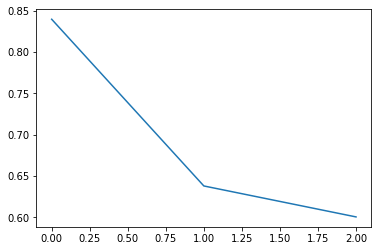

In [11]:
plt.plot(result.history['loss'])
plt.show()
model.reset_states()

## Try Trained Model

In [12]:
start = np.zeros((1, 10))
start[0, 0] = 1
start[0,1] = 2
x,s = model_continue([start, np.zeros((1, config.rnn_size))])

In [13]:
model_continue.layers[2].return_sequences=False

## Save Model

In [14]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model_continue, '../model')

## Save Config

In [15]:
import json

model_info = asdict(config)
model_info['stoi'] = vocab_stoi
model_info['vocab'] = all_selfies_symbols


with open('../src/lib/model_info.json', 'w') as f:
    json.dump(model_info, f)
    print(json.dumps(model_info, indent=2))

{
  "vocab_size": 128,
  "example_number": 20000,
  "batch_size": 64,
  "buffer_size": 1000,
  "embedding_dim": 256,
  "rnn_size": 128,
  "stoi": {
    "[nop]": 0,
    "[\\S-expl]": 1,
    "[/NH+expl]": 2,
    "[=OH+expl]": 3,
    "[S@@expl]": 4,
    "[\\C]": 5,
    "[Branch1_3]": 6,
    "[NHexpl]": 7,
    "[NH2+expl]": 8,
    "[/S@expl]": 9,
    "[P]": 10,
    "[/C@Hexpl]": 11,
    "[F]": 12,
    "[/S-expl]": 13,
    "[\\O]": 14,
    "[=C]": 15,
    "[=PH2expl]": 16,
    "[P@expl]": 17,
    "[S]": 18,
    "[/Cl]": 19,
    "[P@@Hexpl]": 20,
    "[#C]": 21,
    "[=P]": 22,
    "[\\C@@Hexpl]": 23,
    "[=N]": 24,
    "[\\S]": 25,
    "[N+expl]": 26,
    "[/N]": 27,
    "[P@@expl]": 28,
    "[C@@expl]": 29,
    "[=N+expl]": 30,
    "[=NH2+expl]": 31,
    "[Expl=Ring1]": 32,
    "[\\N-expl]": 33,
    "[/C@@Hexpl]": 34,
    "[=S@expl]": 35,
    "[NH+expl]": 36,
    "[C@expl]": 37,
    "[C@Hexpl]": 38,
    "[/N+expl]": 39,
    "[=O]": 40,
    "[=P@@expl]": 41,
    "[Cl]": 42,
    "[\\NH+expl